In [661]:
import mediapipe as mp
import cv2
import time
import numpy as np
import torch
import torch.nn as nn
import torch.utils as utils
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

In [637]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [638]:
classes = ("down", "up", "stop", "thumbright", "thumbleft", "right", "left", "background")

In [639]:
hands = mp_hands.Hands(min_detection_confidence=0.6, min_tracking_confidence=0.3, static_image_mode=True, max_num_hands=1)

In [640]:
train_data = []
train_labels = []

for class_index, gesture_class in enumerate(classes):
    for i in range(175):
        try:
            image = cv2.imread(f"../training/{gesture_class}.{i}.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # changes from bgr to rgb since cv2 is bgr but mediapipe requires rgb
        except:
            continue
        image.flags.writeable = False
        results = hands.process(image) # this makes the actual detections
        
        landmarks = []
        if results.multi_hand_landmarks:
            for landmark in results.multi_hand_landmarks[0].landmark:
                x, y = landmark.x, landmark.y
                landmarks.append([x,y])
            train_label = np.zeros([len(classes)])
            train_label[class_index] = 1
            train_data.append(landmarks)
            train_labels.append(train_label)

[ WARN:0@194170.327] global loadsave.cpp:248 findDecoder imread_('../training/down.100.jpg'): can't open/read file: check file path/integrity
[ WARN:0@194170.327] global loadsave.cpp:248 findDecoder imread_('../training/down.101.jpg'): can't open/read file: check file path/integrity
[ WARN:0@194170.328] global loadsave.cpp:248 findDecoder imread_('../training/down.102.jpg'): can't open/read file: check file path/integrity
[ WARN:0@194170.328] global loadsave.cpp:248 findDecoder imread_('../training/down.103.jpg'): can't open/read file: check file path/integrity
[ WARN:0@194170.328] global loadsave.cpp:248 findDecoder imread_('../training/down.104.jpg'): can't open/read file: check file path/integrity
[ WARN:0@194170.328] global loadsave.cpp:248 findDecoder imread_('../training/down.105.jpg'): can't open/read file: check file path/integrity
[ WARN:0@194170.328] global loadsave.cpp:248 findDecoder imread_('../training/down.106.jpg'): can't open/read file: check file path/integrity
[ WARN

In [641]:
train_data = torch.tensor(train_data)
train_labels = torch.tensor(train_labels)

In [642]:
train_data.shape

torch.Size([785, 21, 2])

In [643]:
class LandmarksDataset(utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.len = len(y)
        self.transform = transform
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [644]:
training_set = LandmarksDataset(train_data, train_labels)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)

In [646]:
val_data = []
val_labels = []
for class_index, gesture_class in enumerate(classes):
    for i in range(40):
        image = cv2.imread(f"../validation/{gesture_class}.{i}.jpg")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # changes from bgr to rgb since cv2 is bgr but mediapipe requires rgb
        image.flags.writeable = False
        results = hands.process(image) # this makes the actual detections
        
        landmarks = []
        if results.multi_hand_landmarks:
            for landmark in results.multi_hand_landmarks[0].landmark:
                x, y = landmark.x, landmark.y
                landmarks.append([x,y])
            val_label = np.zeros([len(classes)])
            val_label[class_index] = 1
            val_data.append(landmarks)
            val_labels.append(val_label)

In [647]:
val_data = torch.tensor(val_data)
val_labels = torch.tensor(val_labels)

In [670]:
validation_set = LandmarksDataset(val_data, val_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

In [672]:
val_data.shape

torch.Size([310, 21, 2])

In [877]:
class HandNetwork(nn.Module):
    def __init__(self, classes):
        super(HandNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.LeakyReLU()
        self.fc1 = nn.Linear(42, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, len(classes))
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [878]:
model = HandNetwork()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.1)

In [879]:
def train_one_epoch(curr_model):
    running_loss = 0
    last_loss = 0

    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = curr_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward() # calculate the gradients
        optimizer.step() # update the params

        running_loss += loss.item()
        if i % 10 == 10-1:
            last_loss = running_loss / 10 # loss per batch
            print(f'  batch {i+1} loss: {last_loss}')
            running_loss = 0
    
    return last_loss

EPOCH 1:
  batch 10 loss: 2.0878557950258254
  batch 20 loss: 2.089493823051453
  batch 30 loss: 2.0923880636692047
  batch 40 loss: 2.069521629810333
  batch 50 loss: 2.0760524809360503
  batch 60 loss: 2.0797445118427276
  batch 70 loss: 2.079218715429306
  batch 80 loss: 2.0730791211128237
  batch 90 loss: 2.074336850643158
  batch 100 loss: 2.0800801157951354
  batch 110 loss: 2.0845657348632813
  batch 120 loss: 2.0685907304286957
  batch 130 loss: 2.092177817225456
  batch 140 loss: 2.0694621056318283
  batch 150 loss: 2.0737272053956985
  batch 160 loss: 2.0867038160562514
  batch 170 loss: 2.071632382273674
  batch 180 loss: 2.0726309686899187
  batch 190 loss: 2.058249536156654
LOSS train 2.058249536156654 valid 2.0792298187048006
EPOCH 2:
  batch 10 loss: 2.0570902675390244
  batch 20 loss: 2.0671949476003646
  batch 30 loss: 2.072288540005684
  batch 40 loss: 2.079743266105652
  batch 50 loss: 2.068570080399513
  batch 60 loss: 2.064772054553032
  batch 70 loss: 2.0603632986

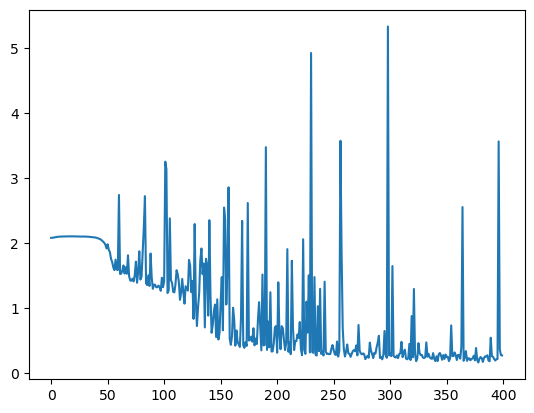

In [880]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

#This is doing some logging that we don't need to worry about right now.
epoch_number = 0
EPOCHS = 400
best_vloss = 1_000_000.
val_history = []
best_model = model

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    model.train(True)
    
    avg_loss = train_one_epoch(curr_model=model)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    val_history.append(avg_vloss.detach().numpy())
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        torch.save(model, "../models/model9.pth")
    epoch_number += 1

plt.plot(range(EPOCHS), val_history)

In [881]:
best_vloss

tensor(0.1615, dtype=torch.float64, grad_fn=<DivBackward0>)

In [882]:
import torch.nn.functional as F
from sklearn.metrics import f1_score

In [883]:
model = torch.load("../models/model9.pth")

In [884]:
model.eval()
correct_count = 0
total = len(validation_set)
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        inputs, labels = vdata
        outputs = torch.argmax(model(inputs), dim=1)
        labels = torch.argmax(labels, dim=1)
        correct_count += (outputs==labels).sum().item()

In [885]:
correct_count/total

0.9741935483870968

In [886]:
f1_score(np.argmax(model(val_data).detach().numpy(), axis=1), np.argmax(val_labels.detach().numpy(), axis=1), average='micro')

0.9741935483870968

from sklearn.neighbors import KNeighborsClassifier

In [586]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [587]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_data.view(-1,21*2), train_labels)
y_pred = knn.predict(val_data.view(-1,21*2))
accuracy_score(val_labels, y_pred)

0.5580645161290323

In [588]:
from sklearn.linear_model import RidgeClassifierCV

In [589]:
train_data.shape

torch.Size([699, 21, 2])

In [590]:
clf = RidgeClassifierCV()
clf.fit(train_data.view(-1, 21*2), train_labels)
y_pred = clf.predict(val_data.view(-1, 21*2))
accuracy_score(val_labels, y_pred)

0.5193548387096775

In [591]:
F.softmax(torch.tensor(clf.decision_function(val_data.view(-1, 21*2))))

/var/folders/xw/slcw2lz14snfvxp49xgqmr880000gn/T/ipykernel_86164/1044316036.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(torch.tensor(clf.decision_function(val_data.view(-1, 21*2))))


tensor([[0.4573, 0.0484, 0.0896,  ..., 0.0850, 0.0911, 0.0797],
        [0.4173, 0.0532, 0.1257,  ..., 0.0936, 0.0882, 0.0599],
        [0.4564, 0.0462, 0.0918,  ..., 0.0855, 0.0899, 0.0812],
        ...,
        [0.0744, 0.0594, 0.1351,  ..., 0.1360, 0.1033, 0.1548],
        [0.0907, 0.0860, 0.1948,  ..., 0.1134, 0.1084, 0.0952],
        [0.0876, 0.0802, 0.1651,  ..., 0.1132, 0.1127, 0.1029]],
       dtype=torch.float64)

In [592]:
clf.score(val_data.view(-1, 21*2), val_labels)

0.5193548387096775

In [593]:
from sklearn.svm import LinearSVC

In [111]:
clf = LinearSVC(multi_class="ovr")
clf.fit(train_data.view(-1, 21*2), torch.argmax(train_labels, dim=1))
clf.score(val_data.view(-1, 21*2), torch.argmax(val_labels, dim=1))

/Users/reetinav/anaconda3/envs/PIC16B/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.8888888888888888

In [112]:
F.softmax(torch.tensor(clf.decision_function(val_data.view(-1, 21*2))), dim=1)

tensor([[0.5952, 0.0090, 0.0528,  ..., 0.0620, 0.0913, 0.0809],
        [0.5499, 0.0127, 0.0850,  ..., 0.0669, 0.0768, 0.0737],
        [0.5842, 0.0089, 0.0531,  ..., 0.0594, 0.0923, 0.0878],
        ...,
        [0.0690, 0.1502, 0.1629,  ..., 0.1562, 0.0389, 0.0815],
        [0.0903, 0.0719, 0.4556,  ..., 0.0353, 0.1396, 0.1260],
        [0.0648, 0.0662, 0.5327,  ..., 0.0554, 0.0969, 0.1004]],
       dtype=torch.float64)